In [65]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict, traceplot, visualize_prior, model_graph, plot_elbo
from libs.model_minibatch_series import HGPforecaster, PiecewiseLinearChangepoints
import numpy as np
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from scipy import stats
import theano
theano.config.compute_test_value='raise'

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
prison = pd.read_csv('../data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')
dates_ = prison['t'].astype('datetime64[ns]')

In [4]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')

In [5]:
groups_input = {
    'state': [0],
    'gender': [1],
    'legal': [2]
}

In [6]:
groups = generate_groups_data_flat(y = prison_pivot, 
                               groups_input = groups_input, 
                               seasonality=4, 
                               h=8)

Number of groups: 3
	state: 8
	gender: 2
	legal: 2
Total number of series: 32
Number of points per series for train: 40
Total number of points: 48
Seasonality: 4
Forecast horizon: 8


In [28]:
#groups = generate_groups_data_matrix(groups)

groups['predict']['data'] = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T

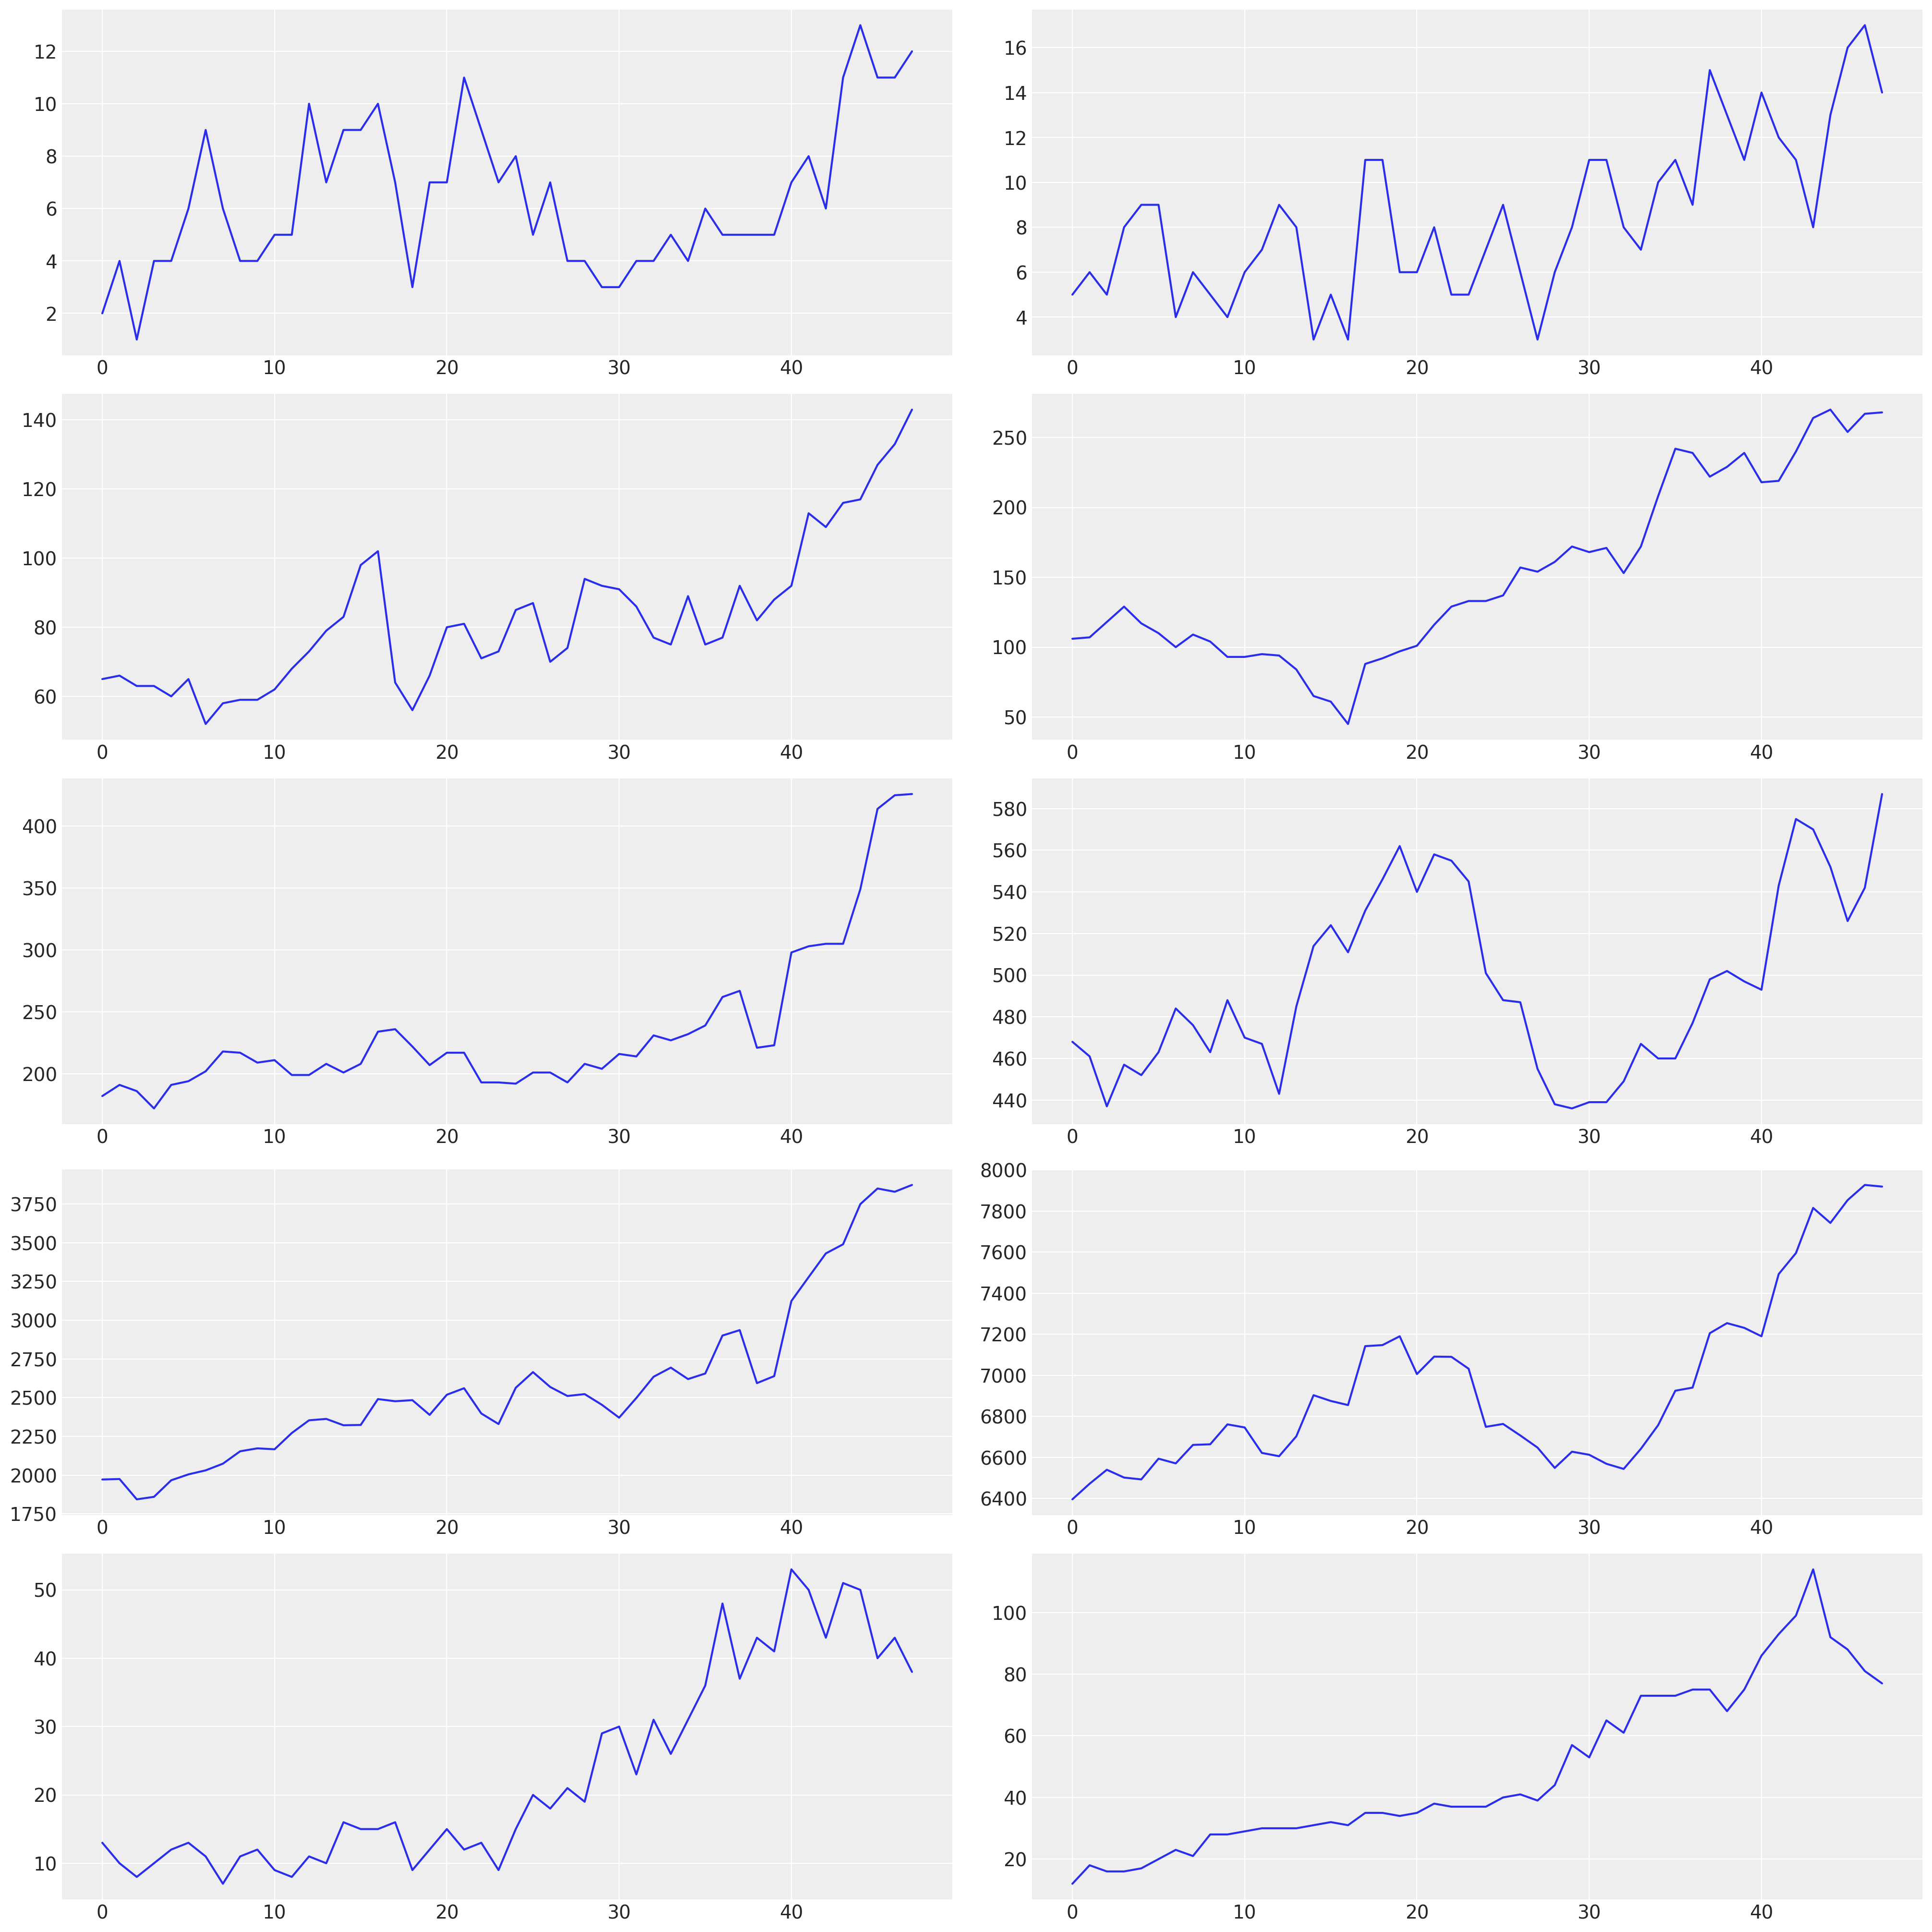

In [31]:
fig, ax = plt.subplots(5, 2, figsize=(20, 20))

ax = ax.ravel()

for i in range(10):
    ax[i].plot(groups['predict']['data'][:,i])

We are adding normaly distributed noise to the data and for every 5 points in 100 we are creating an outlier. To define the outlier we use a uniform distribution from 1.5 to 2 times the median (< or > U(1.5,2) $\cdot$ median).

$$\begin{align}
&I_{ij} = \text{Bern}(0.5) \\
&N_{ij} = \mathcal{N}(0, \frac{\sigma_{Z_j}}{2}) \\
&O_{ij} = \text{Bern}(0.05) \\
&M_{ij} = \text{U}(1.5, 2) \\
&Z_{ij} + N_{ij} + O_{ij} \cdot median(Z_j) \cdot (M_{ij} \cdot I_{ij} - M_{ij} \cdot (1-I_{ij})\end{align}$$

In [106]:
μ_noise = 0
σ_noise = np.std(groups['predict']['data'], axis=0)/2

I = stats.bernoulli.rvs(0.5, size=(groups['predict']['n'],groups['predict']['s']))
O = stats.bernoulli.rvs(0.05, size=(groups['predict']['n'], groups['predict']['s']))
N = np.random.normal(μ_noise, σ_noise, size=(groups['predict']['n'], groups['predict']['s']))

data_w_noise = (groups['predict']['data'] + N + O 
                * np.median(groups['predict']['data'][:,0]) * (1.5 * I - 1.5*(1-I)))

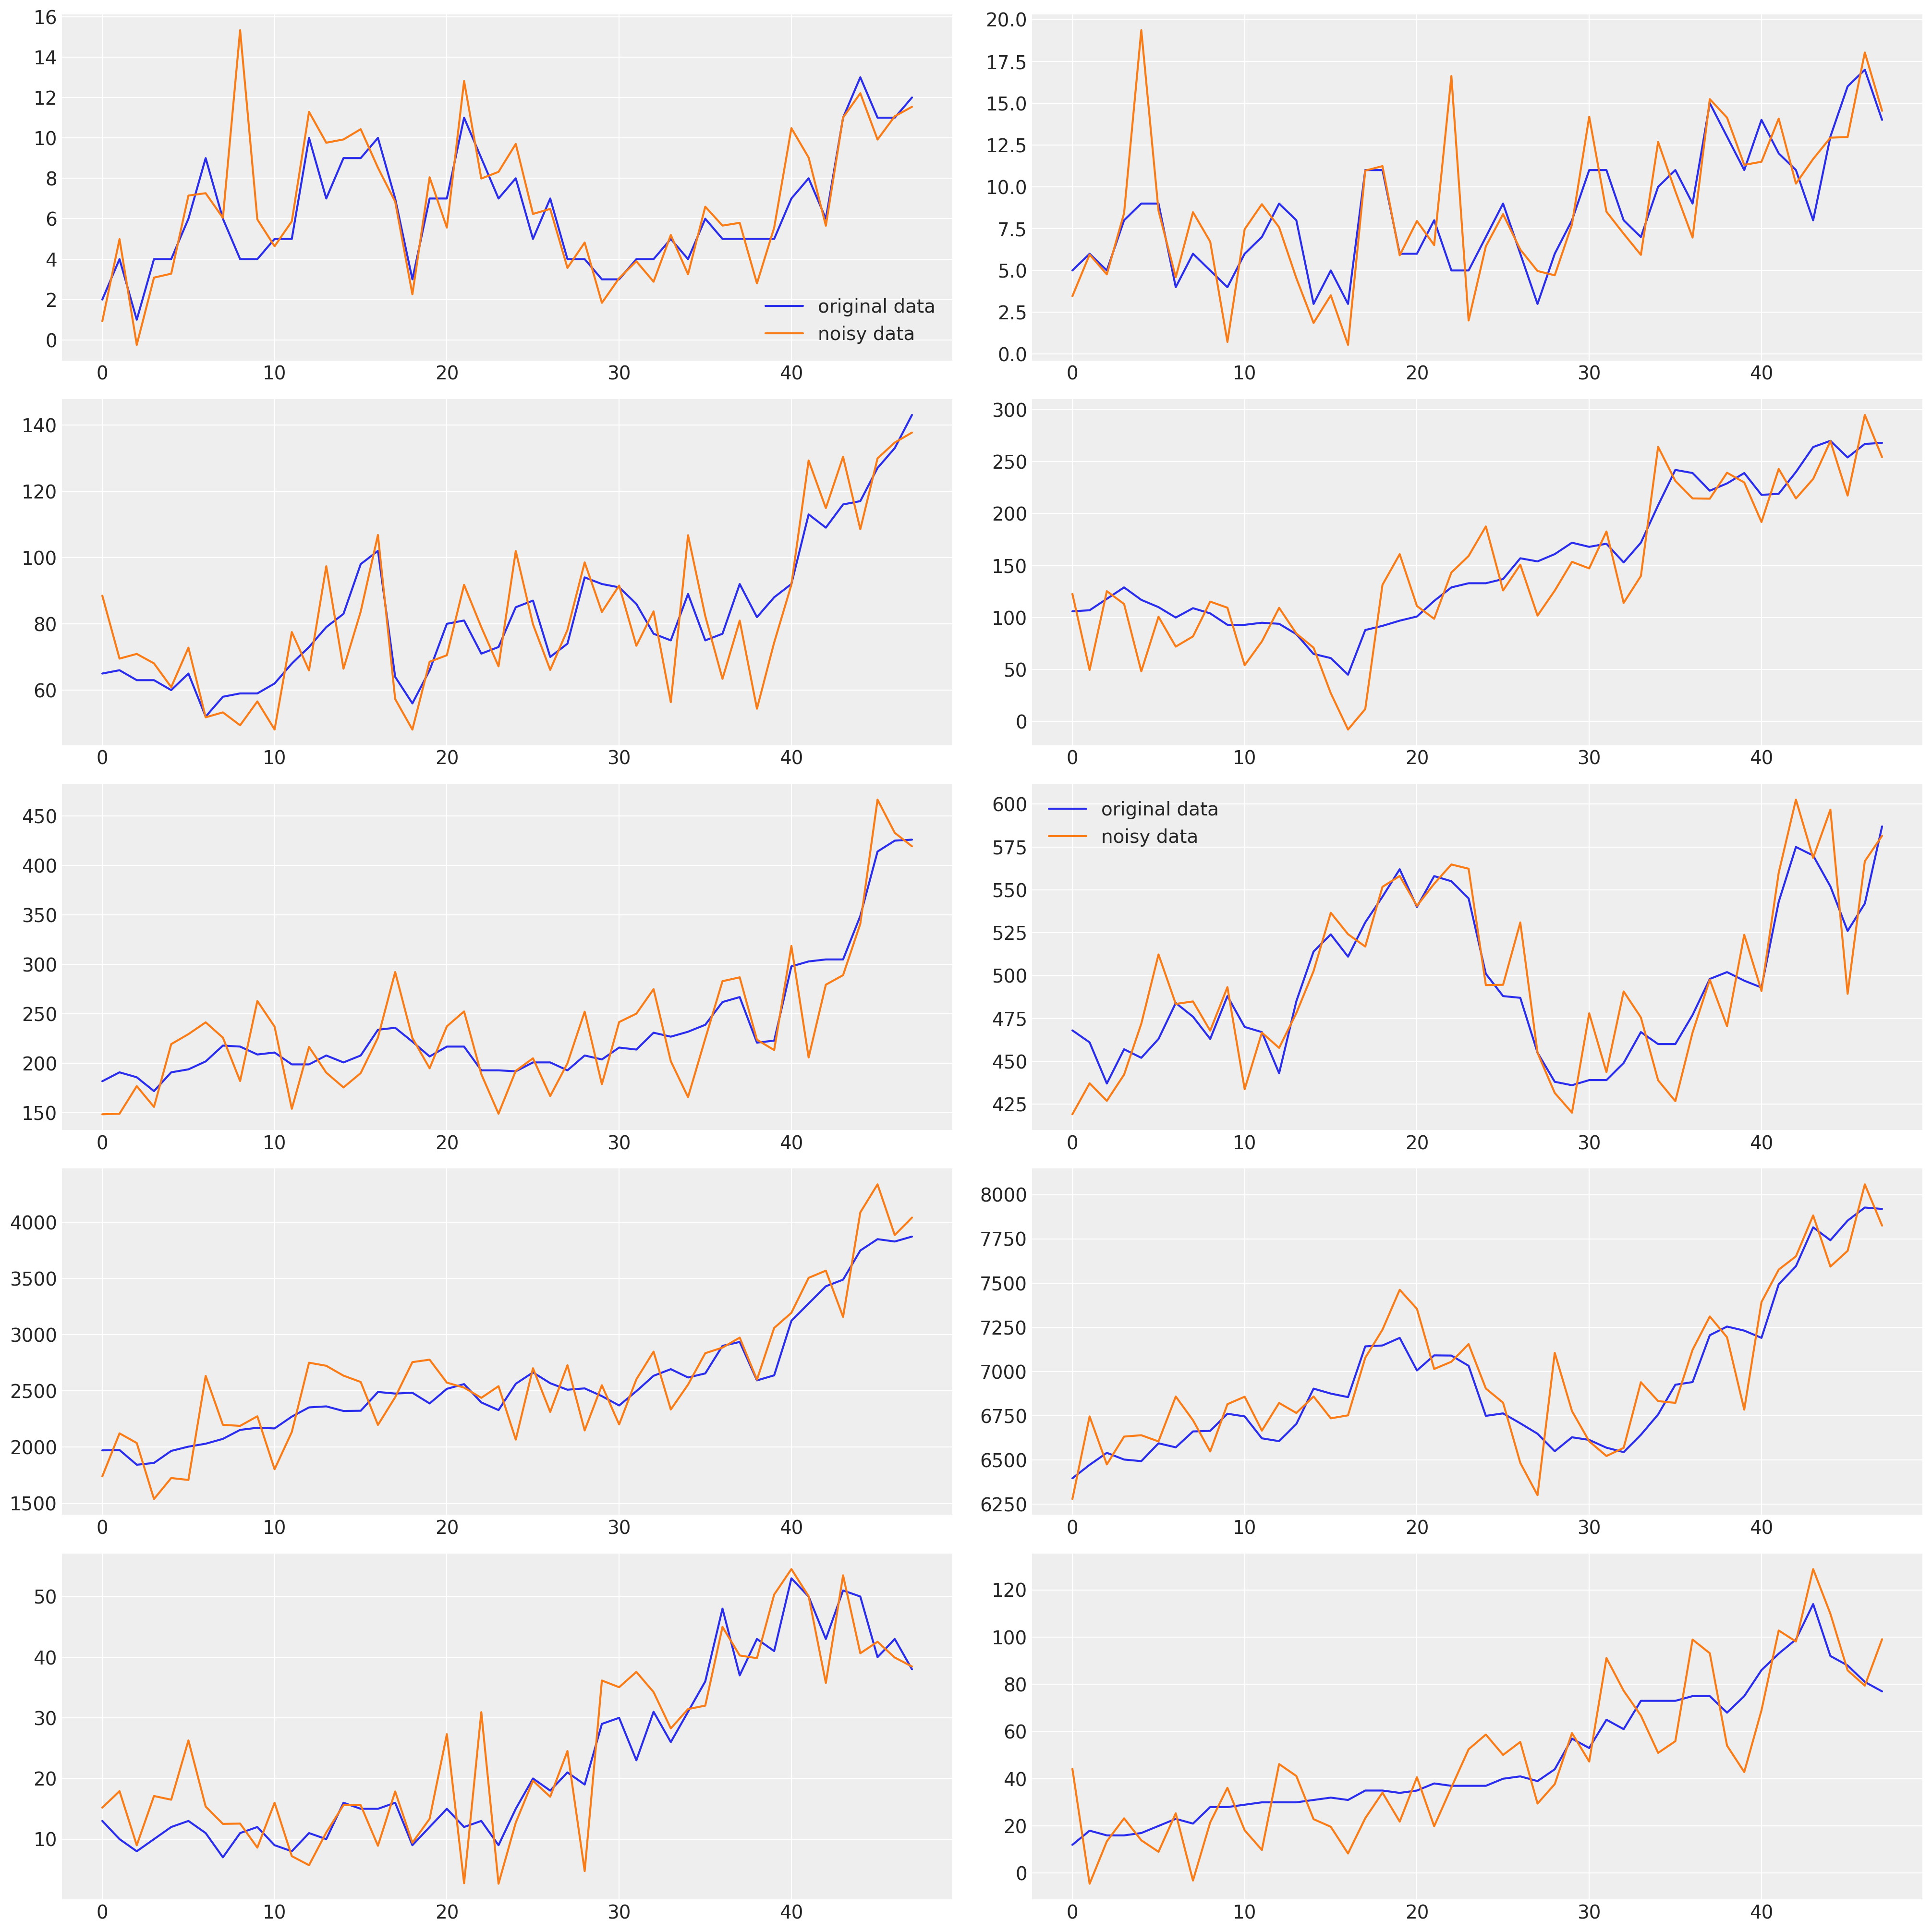

In [107]:
fig, ax = plt.subplots(5, 2, figsize=(20, 20))

ax = ax.ravel()

for i in range(10):
    ax[i].plot(np.arange(groups['predict']['n']),groups['predict']['data'][:,i], label='original data')
    ax[i].plot(np.arange(groups['predict']['n']), data_w_noise[:,i], label='noisy data')
    if i%5==0:
        ax[i].legend()

In [7]:
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  changepoints=4,
                  minibatch=[groups['train']['n'], 15])

In [8]:
m.fit_vi()

Fitting model...


Finished [100%]: Average Loss = 38,810


Sampling...


In [11]:
m.predict()

Sampling...


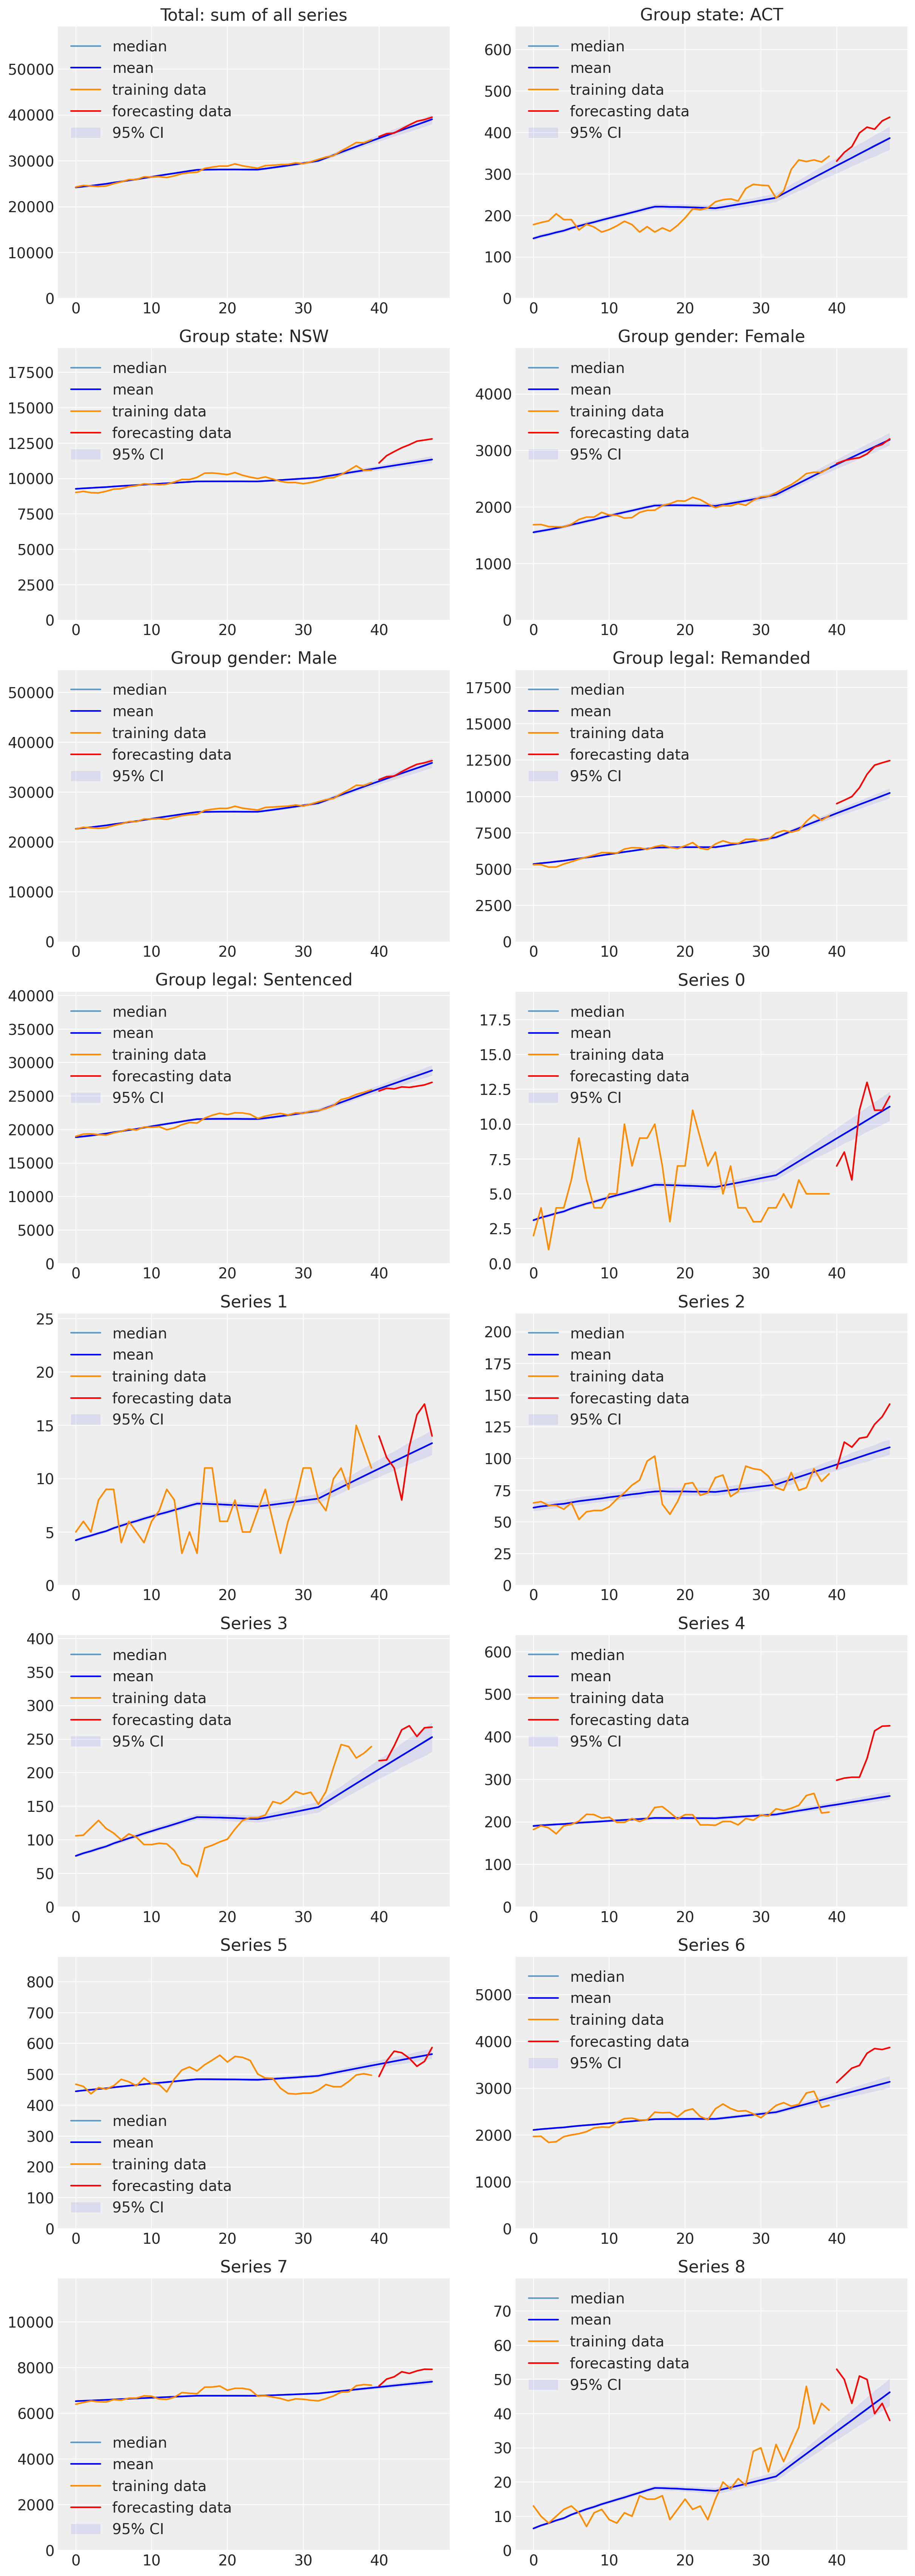

In [13]:
visualize_predict(groups, m.pred_samples_predict, 10)

In [14]:
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)